<center><h2>ALTeGraD 2021<br>Lab Session 1: HAN</h2><h3>Hierarchical Attention Network Using GRU</h3> 09 / 11 / 2021<br> M. Kamal Eddine, H. Abdine</center>




In [156]:
# In case you are using google colab:
# uncomment the following two lines: 

%tensorflow_version 1.9
!pip install keras==2.2.5

!wget -c "https://onedrive.live.com/download?cid=AE69638675180117&resid=AE69638675180117%2199289&authkey=AHgxt3xmgG0Fu5A" -O "data.zip"
!unzip data.zip

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.9`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
--2021-11-16 19:11:57--  https://onedrive.live.com/download?cid=AE69638675180117&resid=AE69638675180117%2199289&authkey=AHgxt3xmgG0Fu5A
Resolving onedrive.live.com (onedrive.live.com)... 13.107.43.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.43.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://vqtlqw.am.files.1drv.com/y4m04awDZZ68KFos1FsPvDbhb5rkgowfzZcdOXuDkjQwqFc94mkdvirX8MW6CQ97QSP2Dkyl0MPbog0Bcy0mEXQqhZ3HPXuvb4JIGn9ZBx6mno6aBAZfWU6T7MZcA8D9ptlfl3kqXacodTJ5rai-75TKLdPzey44k6rJvLvnBo45YJJgWSxiVqGWcngHiydid2RIVGiJxnIiFQNVfLlyEpkDg/data.zip?download&psid=1 [following]
--2021-11-16 19:11:58--  https://vqtlqw.am.files.1drv.com/y4m04awDZZ68KFos1FsPvDbhb5rkgowfzZcdOXuDkjQwqFc94mkdvirX8MW6CQ97QSP2Dkyl0MPbog0Bcy0mEXQqhZ3HPXuvb4JIGn9ZBx6mno6a

# = = = = = Attention Layer = = = = =

In [157]:
def dot_product(x, kernel):
    """
    https://github.com/richliao/textClassifier/issues/13#issuecomment-377323318
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

In [158]:
import keras.backend as K
from keras.layers import Layer as Layer
from keras import initializers, regularizers, constraints

class AttentionWithContext(Layer):
    """
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """
    
    def __init__(self, return_coefficients=False,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform')
        
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)
        
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
    
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        
        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)
        
        super(AttentionWithContext, self).build(input_shape)
    
    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
    
    def call(self, x, mask=None):
        uit = dot_product(x, self.W)
        
        if self.bias:
            uit += self.b
        
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)
        
        a = K.exp(ait)
        
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
        
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        
        a = K.expand_dims(a)
        weighted_input = a*x ### fill the gap ### # compute the attentional vector
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1),a] ### fill the gap - [attentional vector, coefficients] ###
        else:
            return [K.sum(weighted_input)] ### fill the gap - attentional vector only ###
    
    
    
    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

# = = = = = Bidirectional GRU = = = = =
#### fill the gaps in the bidir_gru function below ###
#### add a RNN-GRU layer and a bidirectional wrapper ###
#### bidirectional: search for 'bidirectional' [here](https://keras.io/layers/wrappers/)
#### GRU: search for 'GRU' [here](https://keras.io/layers/recurrent/)
#### layers can be combined by nesting them as: layer_b(parameters_b)(layer_a(parameters_a)(input))

In [159]:
from keras.layers import Bidirectional, GRU

def bidir_gru(my_seq,n_units):
    '''
    just a convenient wrapper for bidirectional RNN with GRU units
    '''
    return Bidirectional(GRU(n_units,return_sequences=True,activation='tanh'), merge_mode="concat")(my_seq)

# = = = = = Parameters = = = = =

In [160]:
import sys
import json
import operator
import numpy as np

path_root = ''
path_to_data = path_root + 'data/'

d = 30 # dimensionality of word embeddings
n_units = 50 # RNN layer dimensionality
drop_rate = 0.5 # dropout
mfw_idx = 2 # index of the most frequent words in the dictionary 
            # 0 is for the special padding token
            # 1 is for the special out-of-vocabulary token

padding_idx = 0
oov_idx = 1
batch_size = 32
nb_epochs = 6
my_optimizer = 'adam'
my_patience = 2 # for early stopping strategy

# = = = = = Data Loading = = = = =

In [161]:
my_docs_array_train = np.load(path_to_data + 'docs_train.npy')
my_docs_array_test = np.load(path_to_data + 'docs_test.npy')

my_labels_array_train = np.load(path_to_data + 'labels_train.npy')
my_labels_array_test = np.load(path_to_data + 'labels_test.npy')

# load dictionary of word indexes (sorted by decreasing frequency across the corpus)
with open(path_to_data + 'word_to_index.json', 'r') as my_file:
    word_to_index = json.load(my_file)

# invert mapping
index_to_word = dict((v,k) for k,v in word_to_index.items()) ### fill the gap (use a dict comprehension) ###

# = = = = = Defining Architecture = = = = =

In [162]:
from keras.models import Model
from keras.layers import Input, Embedding, Dropout, TimeDistributed, Dense

sent_ints = Input(shape=(my_docs_array_train.shape[2],)) # vec of ints of variable size

sent_wv = Embedding(input_dim=len(index_to_word)+2, # vocab size
                    output_dim=d, # dimensionality of embedding space
                    input_length=my_docs_array_train.shape[2],
                    trainable=True
                    )(sent_ints)

sent_wv_dr = Dropout(drop_rate)(sent_wv)
sent_wa = bidir_gru(sent_wv_dr, n_units) ### fill the gap ### # get the annotations for each word in the sent
sent_att_vec,word_att_coeffs = AttentionWithContext(return_coefficients=True)(sent_wa) ### fill the gap ### # get the attentional vector for the sentence
sent_att_vec_dr = Dropout(drop_rate)(sent_att_vec)                      
sent_encoder = Model(sent_ints,sent_att_vec_dr)

doc_ints = Input(shape=(my_docs_array_train.shape[1],my_docs_array_train.shape[2],))
sent_att_vecs_dr = TimeDistributed(sent_encoder)(doc_ints) ### fill the gap ### # apply the sentence encoder model to each sentence in the document. Search for 'TimeDistributed' in https://keras.io/layers/wrappers/
doc_sa = bidir_gru(sent_att_vecs_dr,n_units) ### fill the gap ### # get annotations for each sent in the doc
doc_att_vec,sent_att_coeffs = AttentionWithContext(return_coefficients=True)(doc_sa) ### fill the gap ### # get attentional vector for the doc
doc_att_vec_dr = Dropout(drop_rate)(doc_att_vec)
                  
preds = Dense(units=1,
              activation='sigmoid')(doc_att_vec_dr)
model = Model(doc_ints,preds)

model.compile(loss='binary_crossentropy',
              optimizer = my_optimizer,
              metrics = ['accuracy'])

print('model compiled')

model compiled


# = = = = = Training = = = = =

In [163]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

loading_pretrained = False

if not loading_pretrained:
    early_stopping = EarlyStopping(monitor='val_acc',
                                   patience=my_patience,
                                   mode='max')
    
    # save model corresponding to best epoch
    checkpointer = ModelCheckpoint(filepath=path_to_data + 'model', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True)
    
    # 200s/epoch on CPU - reaches 84.38% accuracy in 2 epochs
    ### fill the gap ### # call the .fit() method on your model with the arguments: my_docs_array_train, my_labels_array_train, batch_size, nb_epochs, my_docs_array_test, my_labels_array_test, early_stopping
    # look at: https://keras.io/models/sequential/#fit
    model.fit(
        x = my_docs_array_train, 
        y = my_labels_array_train, 
        batch_size= batch_size, 
        epochs = nb_epochs, 
        callbacks = [early_stopping], 
        validation_data=(my_docs_array_test, my_labels_array_test)) # checkpointer

else:
    model.load_weights(path_to_data + 'model')

Train on 25000 samples, validate on 25000 samples
Epoch 1/6
25000/25000 [==============================] - 117s 5ms/step - loss: 0.4547 - acc: 0.7682 - val_loss: 0.3580 - val_acc: 0.8419
Epoch 2/6
25000/25000 [==============================] - 111s 4ms/step - loss: 0.2689 - acc: 0.8918 - val_loss: 0.4128 - val_acc: 0.8252
Epoch 3/6
25000/25000 [==============================] - 111s 4ms/step - loss: 0.1889 - acc: 0.9291 - val_loss: 0.4503 - val_acc: 0.8175


# = = = = = Extraction of Attention Coefficients = = = = =

In [164]:
from keras.models import Model

# define intermediate models
### fill the two gaps below ###
get_word_att_coeffs = Model(sent_ints,word_att_coeffs) # attention coeffs over the words in a sent
get_sent_attention_coeffs = Model(doc_ints, sent_att_coeffs) # attention coeffs over the sents in the doc


my_review = my_docs_array_test[-1:,:,:] # select last review
# convert integer review to text
index_to_word[1] = 'OOV'
my_review_text = [[index_to_word[idx] for idx in sent if idx in index_to_word] for sent in my_review.tolist()[0]]


# = = = = = Attention Over Sentences in the Document = = = = =

In [165]:
sent_coeffs = get_sent_attention_coeffs.predict(my_review)
sent_coeffs = sent_coeffs[0,:,:]
for elt in zip(sent_coeffs[:,0].tolist(),[' '.join(elt) for elt in my_review_text]):
    print(round(elt[0]*100,2),elt[1])

6.31 There 's a sign on The Lost Highway that says : OOV SPOILERS OOV ( but you already knew that , did n't you ? )
10.11 Since there 's a great deal of people that apparently did not get the point of this movie , I 'd like to contribute my interpretation of why the plot
6.5 As others have pointed out , one single viewing of this movie is not sufficient .
14.72 If you have the DVD of MD , you can OOV ' by looking at David Lynch 's 'Top 10 OOV to OOV MD ' ( but only upon second
22.53 ; ) First of all , Mulholland Drive is downright brilliant .
25.17 A masterpiece .
14.67 This is the kind of movie that refuse to leave your head .


# = = = = = Attention Over Words in Each Sentence = = = = =

In [166]:
from keras.backend.tensorflow_backend import _to_tensor

my_review_tensor = _to_tensor(my_review,dtype='float32') # a layer, unlike a model, requires a TensorFlow tensor as input

word_coeffs = word_coeffs = TimeDistributed(get_word_att_coeffs)(my_review_tensor)  ### fill the gap ### # get the word attentional coefficients for each sentence in the document
word_coeffs = K.eval(word_coeffs) # shape = (1, 7, 30, 1): (batch size, nb of sents in doc, nb of words per sent, coeff)
word_coeffs = word_coeffs[0,:,:,0] # shape = (7, 30) (coeff for each word in each sentence)
word_coeffs = sent_coeffs * word_coeffs # re-weight by sentence importance
word_coeffs = np.round((word_coeffs*100).astype(np.float64),2)

word_coeffs_list = word_coeffs.tolist()
# match text and coefficients
text_word_coeffs = [list(zip(words,word_coeffs_list[idx][:len(words)])) for idx,words in enumerate(my_review_text)]

for sent in text_word_coeffs:
    [print(elt) for elt in sent]  
    print('= = = =')

# sort words by importance within each sentence
text_word_coeffs_sorted = [sorted(elt,key=operator.itemgetter(1),reverse=True) for elt in text_word_coeffs]


for sent in text_word_coeffs_sorted:
    [print(elt) for elt in sent]
    print('= = = =')


('There', 0.02)
("'s", 0.03)
('a', 0.04)
('sign', 0.02)
('on', 0.19)
('The', 0.25)
('Lost', 3.27)
('Highway', 0.43)
('that', 0.21)
('says', 0.08)
(':', 0.04)
('OOV', 0.03)
('SPOILERS', 0.03)
('OOV', 0.02)
('(', 0.02)
('but', 0.01)
('you', 0.3)
('already', 0.09)
('knew', 0.14)
('that', 0.08)
(',', 0.03)
('did', 0.02)
("n't", 0.01)
('you', 0.05)
('?', 0.01)
(')', 0.25)
= = = =
('Since', 0.34)
('there', 0.22)
("'s", 0.31)
('a', 0.6)
('great', 7.01)
('deal', 1.13)
('of', 0.15)
('people', 0.2)
('that', 0.06)
('apparently', 0.01)
('did', 0.02)
('not', 0.01)
('get', 0.02)
('the', 0.01)
('point', 0.0)
('of', 0.0)
('this', 0.0)
('movie', 0.0)
(',', 0.0)
('I', 0.0)
("'d", 0.0)
('like', 0.0)
('to', 0.0)
('contribute', 0.0)
('my', 0.0)
('interpretation', 0.0)
('of', 0.0)
('why', 0.0)
('the', 0.0)
('plot', 0.0)
= = = =
('As', 0.21)
('others', 0.35)
('have', 0.1)
('pointed', 0.06)
('out', 0.2)
(',', 0.19)
('one', 0.2)
('single', 0.1)
('viewing', 0.75)
('of', 0.13)
('this', 0.16)
('movie', 0.22)
('is

## Plotting the results

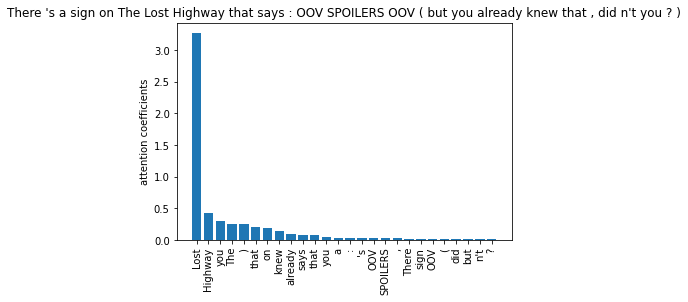

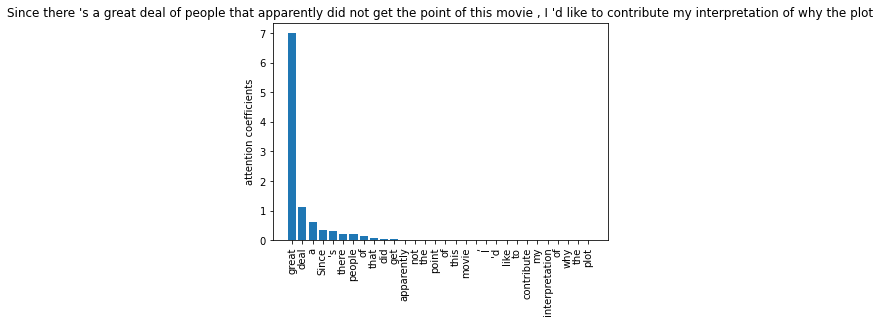

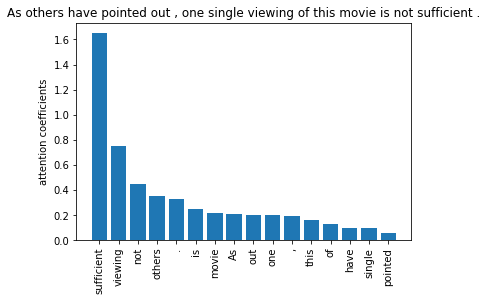

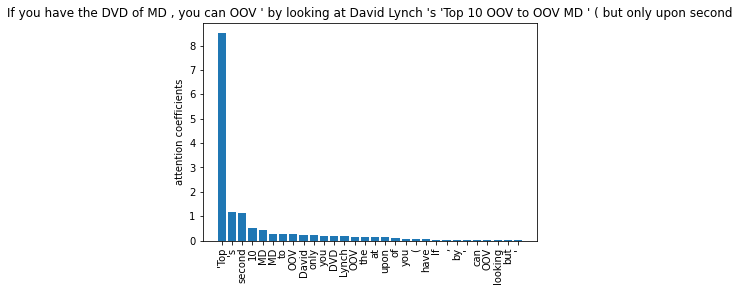

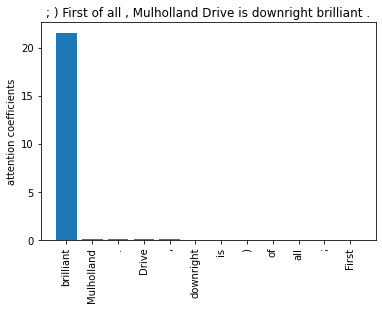

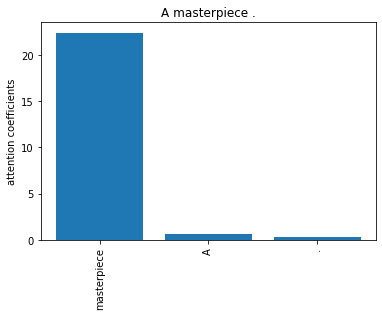

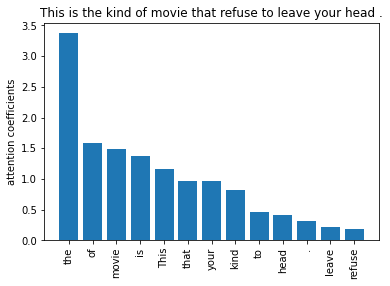

In [167]:
for i in range(len(text_word_coeffs_sorted)):
  words,attcoeffs = zip(*text_word_coeffs_sorted[i])
  title=' '.join(my_review_text[i])
  plt.title(f"{title}")
  plt.ylabel("attention coefficients")
  y_pos = np.arange(len(words))
  plt.bar(y_pos, attcoeffs)
  plt.xticks(y_pos, words, rotation=90)
  plt.show()